<a href="https://colab.research.google.com/github/fannyfdlsa/Cataract_model_detection/blob/main/VGG16_(epoch_15).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Library

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split

import tensorflow as tf

# Define Dataset

In [ ]:
# Paths for the main dataset and output directory
dataset_path = '/content/drive/MyDrive/cataract_data/cataract_class'
output_path = '/content/drive/MyDrive/cataract_data/augmented'

os.makedirs(output_path, exist_ok=True)

# Preprocessing Data

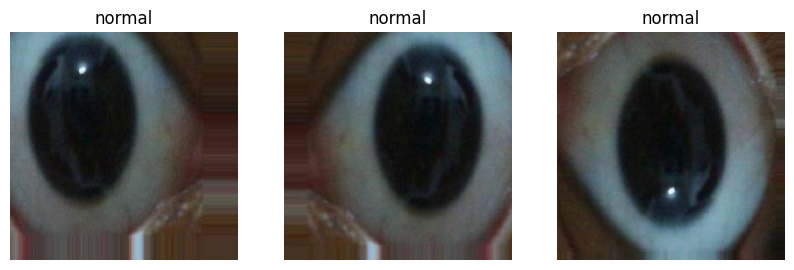

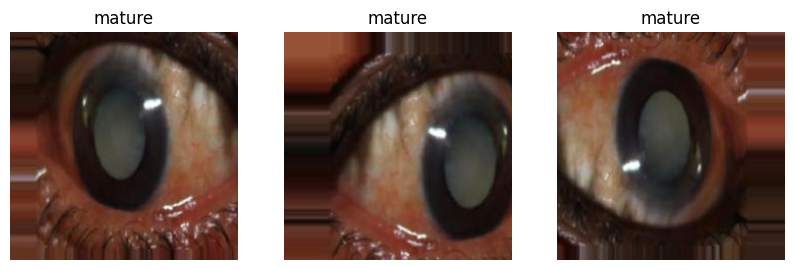

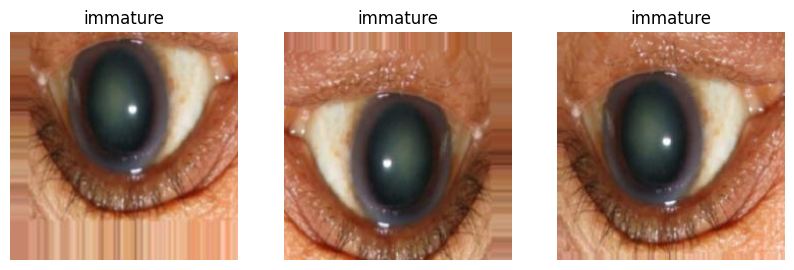

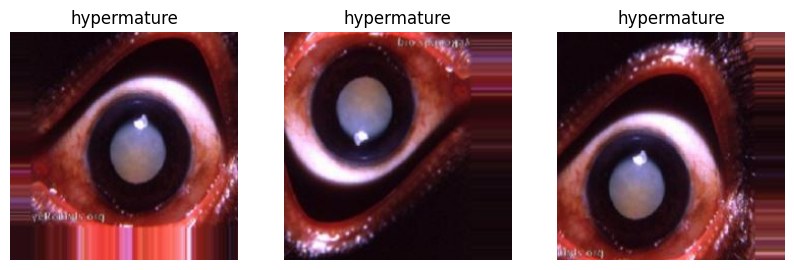

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

valid_extensions = ('.jpg', '.jpeg', '.png')
classes = ('normal', 'mature', 'immature', 'hypermature')
target_size = (224, 224)

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    output_class_path = os.path.join(output_path, class_name)
    os.makedirs(output_class_path, exist_ok=True)

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        if img_path.lower().endswith(valid_extensions):
            img = load_img(img_path, target_size=target_size)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=output_class_path, save_prefix='aug', save_format='jpeg'):
                i += 1
                if i >= 5:
                    break

num_samples_per_class = 3

for class_index, class_name in enumerate(classes):
    class_path = os.path.join(output_path, class_name)

    image_files = os.listdir(class_path)[:num_samples_per_class]

    plt.figure(figsize=(10, 5))

    for i, img_name in enumerate(image_files):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)

        if img is not None:
            plt.subplot(1, num_samples_per_class, i + 1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(f"{classes[class_index]}")
            plt.axis('off')

    plt.show()

# Split Data

In [ ]:
import shutil

# Directories for train, validation, and test
train_dir = '/content/drive/MyDrive/cataract_data/split_data/train'
valid_dir = '/content/drive/MyDrive/cataract_data/split_data/valid'
test_dir = '/content/drive/MyDrive/cataract_data/split_data/test'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Define class_names
class_names = ('normal', 'mature', 'immature', 'hypermature')
for class_name in class_names:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(valid_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    class_path = os.path.join(output_path, class_name)
    image_paths = []

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        if os.path.isfile(img_path) and img_path.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(img_path)

    train_path, temp_path = train_test_split(image_paths, test_size=0.3, random_state=42)

    valid_path, test_path = train_test_split(temp_path, test_size=0.5, random_state=42)

    for img_path in train_path:
        shutil.copy(img_path, os.path.join(train_dir, class_name, os.path.basename(img_path)))
    for img_path in valid_path:
        shutil.copy(img_path, os.path.join(valid_dir, class_name, os.path.basename(img_path)))
    for img_path in test_path:
        shutil.copy(img_path, os.path.join(test_dir, class_name, os.path.basename(img_path)))

    print(f"Class: {class_name}")
    print(f"Total Images: {len(image_paths)}")
    print(f"Train Images: {len(train_path)}")
    print(f"Valid Images: {len(valid_path)}")
    print(f"Test Images: {len(test_path)}")
    print("-" * 20)

Class: normal
Total Images: 998
Train Images: 698
Valid Images: 150
Test Images: 150
--------------------
Class: mature
Total Images: 1003
Train Images: 702
Valid Images: 150
Test Images: 151
--------------------
Class: immature
Total Images: 995
Train Images: 696
Valid Images: 149
Test Images: 150
--------------------
Class: hypermature
Total Images: 995
Train Images: 696
Valid Images: 149
Test Images: 150
--------------------


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/content/drive/MyDrive/cataract_data/split_data/train'
valid_dir = '/content/drive/MyDrive/cataract_data/split_data/valid'
test_dir = '/content/drive/MyDrive/cataract_data/split_data/test'

target_size = (224, 224)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=64,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=target_size,
    batch_size=64,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 2792 images belonging to 4 classes.
Found 598 images belonging to 4 classes.
Found 601 images belonging to 4 classes.


# Building Model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Additional custom classification layers
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,139,524 (80.64 MB)

 Trainable params: 6,424,324 (24.51 MB)

 Non-trainable params: 14,715,200 (56.13 MB)

# Training Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

class TargetAccuracyCallback(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy=0.99):
        super(TargetAccuracyCallback, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        if logs and logs.get('val_accuracy') >= self.target_accuracy:
            print(f"\nReached target validation accuracy of {self.target_accuracy}. Stopping training.")
            self.model.stop_training = True

checkpoint_filepath = '/content/drive/MyDrive/cataract_data/best_model.keras'

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

target_accuracy_callback = TargetAccuracyCallback(target_accuracy=0.99)

history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint, target_accuracy_callback]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.5882 - loss: 1.2521 
Epoch 1: val_accuracy improved from -inf to 0.81605, saving model to /content/drive/MyDrive/cataract_data/best_model.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 2104s 46s/step - accuracy: 0.5902 - loss: 1.2443 - val_accuracy: 0.8161 - val_loss: 0.4644
Epoch 2/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.8446 - loss: 0.4077 
Epoch 2: val_accuracy improved from 0.81605 to 0.84783, saving model to /content/drive/MyDrive/cataract_data/best_model.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 1925s 44s/step - accuracy: 0.8451 - loss: 0.4067 - val_accuracy: 0.8478 - val_loss: 0.3597
Epoch 3/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 36s/step - accuracy: 0.9412 - loss: 0.1935 
Epoch 3: val_accuracy improved from 0.84783 to 0.86789, saving model to /content/drive/MyDrive/cataract_data/best_model.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 1927s 44s/step - accuracy: 0.9412 - loss: 0.1932 - val_accuracy: 0.8679 - val_loss: 0.3286
Epoch 4/15
44/44 ━━━━━━━━━━

#   Evaluasi Model

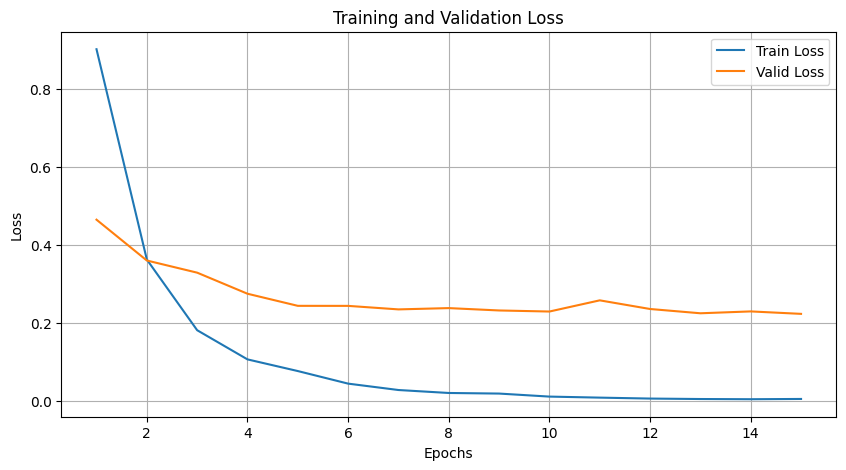

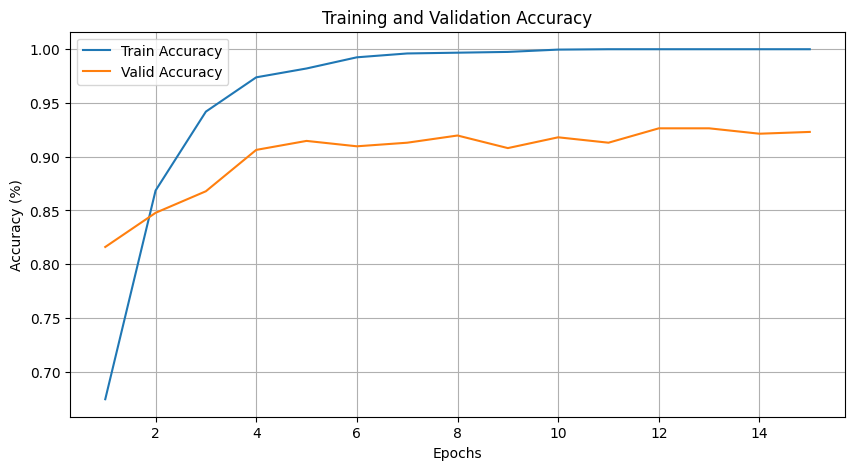

Training completed.


In [ ]:
# Extract training and validation metrics from the history object
train_losses = history.history['loss']
valid_losses = history.history['val_loss']
train_accuracies = history.history['accuracy']
valid_accuracies = history.history['val_accuracy']

num_epochs = len(train_losses)

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

print("Training completed.")

In [ ]:
from tensorflow.keras.models import load_model
best_model = load_model('/content/drive/MyDrive/cataract_data/best_model.keras')

# Evaluate the model on the test set
evaluation = best_model.evaluate(test_generator)

print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

predictions = best_model.predict(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(predictions, axis=1)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Print confusion matrix
print(confusion_matrix(y_true, y_pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 373s 37s/step - accuracy: 0.9511 - loss: 0.1847
Test Loss: 0.19986437261104584
Test Accuracy: 0.941763699054718
10/10 ━━━━━━━━━━━━━━━━━━━━ 348s 34s/step
              precision    recall  f1-score   support

 hypermature       0.97      0.99      0.98       150
    immature       0.93      0.91      0.92       150
      mature       0.92      0.90      0.91       151
      normal       0.95      0.97      0.96       150

    accuracy                           0.94       601
   macro avg       0.94      0.94      0.94       601
weighted avg       0.94      0.94      0.94       601

[[148   1   0   1]
 [  1 136  10   3]
 [  4   8 136   3]
 [  0   2   2 146]]


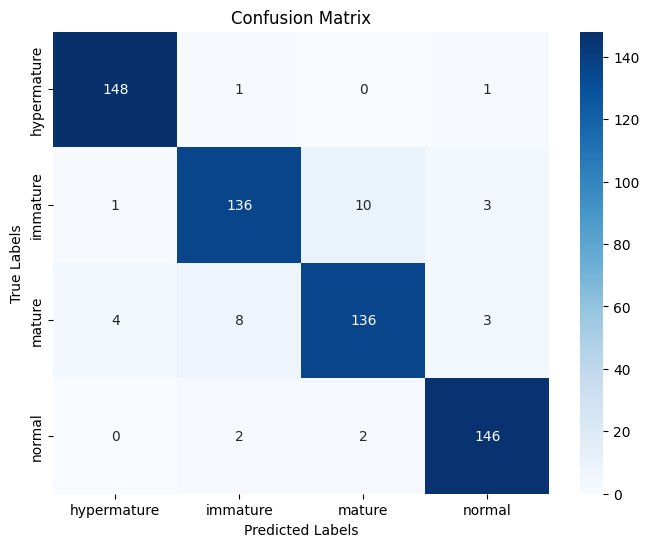

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

results = []
class_names = ('normal', 'mature', 'immature', 'hypermature')

# Iterate through the predictions and true labels
for i in range(len(y_pred)):
    predicted_class = class_names[y_pred[i]]
    true_class = class_names[y_true[i]]

    # Check if the prediction is correct
    correct = predicted_class == true_class

    # Append the results to the list
    results.append({'prediction': predicted_class, 'true': true_class, 'correct': correct})

# Print the results in a formatted way
print("Prediction vs. True Label:")
for item in results:
  print(f"Predicted: {item['prediction']}, True: {item['true']}, Correct: {item['correct']}")

Prediction vs. True Label:
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, Correct: True
Predicted: normal, True: normal, 